# German Car License Plate Recognition

Datenset für das Training der OCR-Erkennung

### Importing Packages

In [1]:
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
from scipy import misc
from skimage import data
import glob
import shutil

print ("TensorFlow Version: {}".format(tf.__version__))

device_name = tf.test.gpu_device_name()

if device_name != "/device:GPU:0":
    raise SystemError("GPU device not found")

print(f"GPU device: {device_name}")

TensorFlow Version: 2.1.0-rc1
GPU device: /device:GPU:0


### Training Parameter

In [2]:
data_path = "D:/development/tensorflow/datasets/clpr"

BATCH_SIZE = 100
NUM_EPOCHS = 1000

IMAGE_WIDTH = 128
IMAGE_HEIGHT = 64

POOL_SIZE = 2
MAX_TEXT_LEN = 10

OPTIMIZER = "adagrad"

OUTPUT_PATH = 'output'
MODEL_NAME = "clpr-model"

MODEL_WEIGHTS_PATH = os.path.sep.join([OUTPUT_PATH, OPTIMIZER, MODEL_NAME]) + '-weights.h5'
MODEL_PATH = os.path.sep.join([OUTPUT_PATH, OPTIMIZER, MODEL_NAME]) + '.h5'

### Data Loading

In [3]:
from pyimagesearch.io import Hdf5DatasetLoader
from sklearn.model_selection import train_test_split

loader = Hdf5DatasetLoader()
X_train, y_train = loader.load(data_path + '/hdf5/train.h5', shuffle=True)
X_test, y_test = loader.load(data_path + '/hdf5/test.h5', shuffle=True)

print("Train dataset size: {}".format(X_train.shape[0]))
print("Test dataset size:  {}".format(X_test.shape[0]))

#images, labels = loader.load(data_path + '/hdf5/train.h5', shuffle=True)
#X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

Train dataset size: 65276
Test dataset size:  16319


C:\Users\Andreas\Anaconda3\envs\dl4cv\lib\site-packages\matplotlib\text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


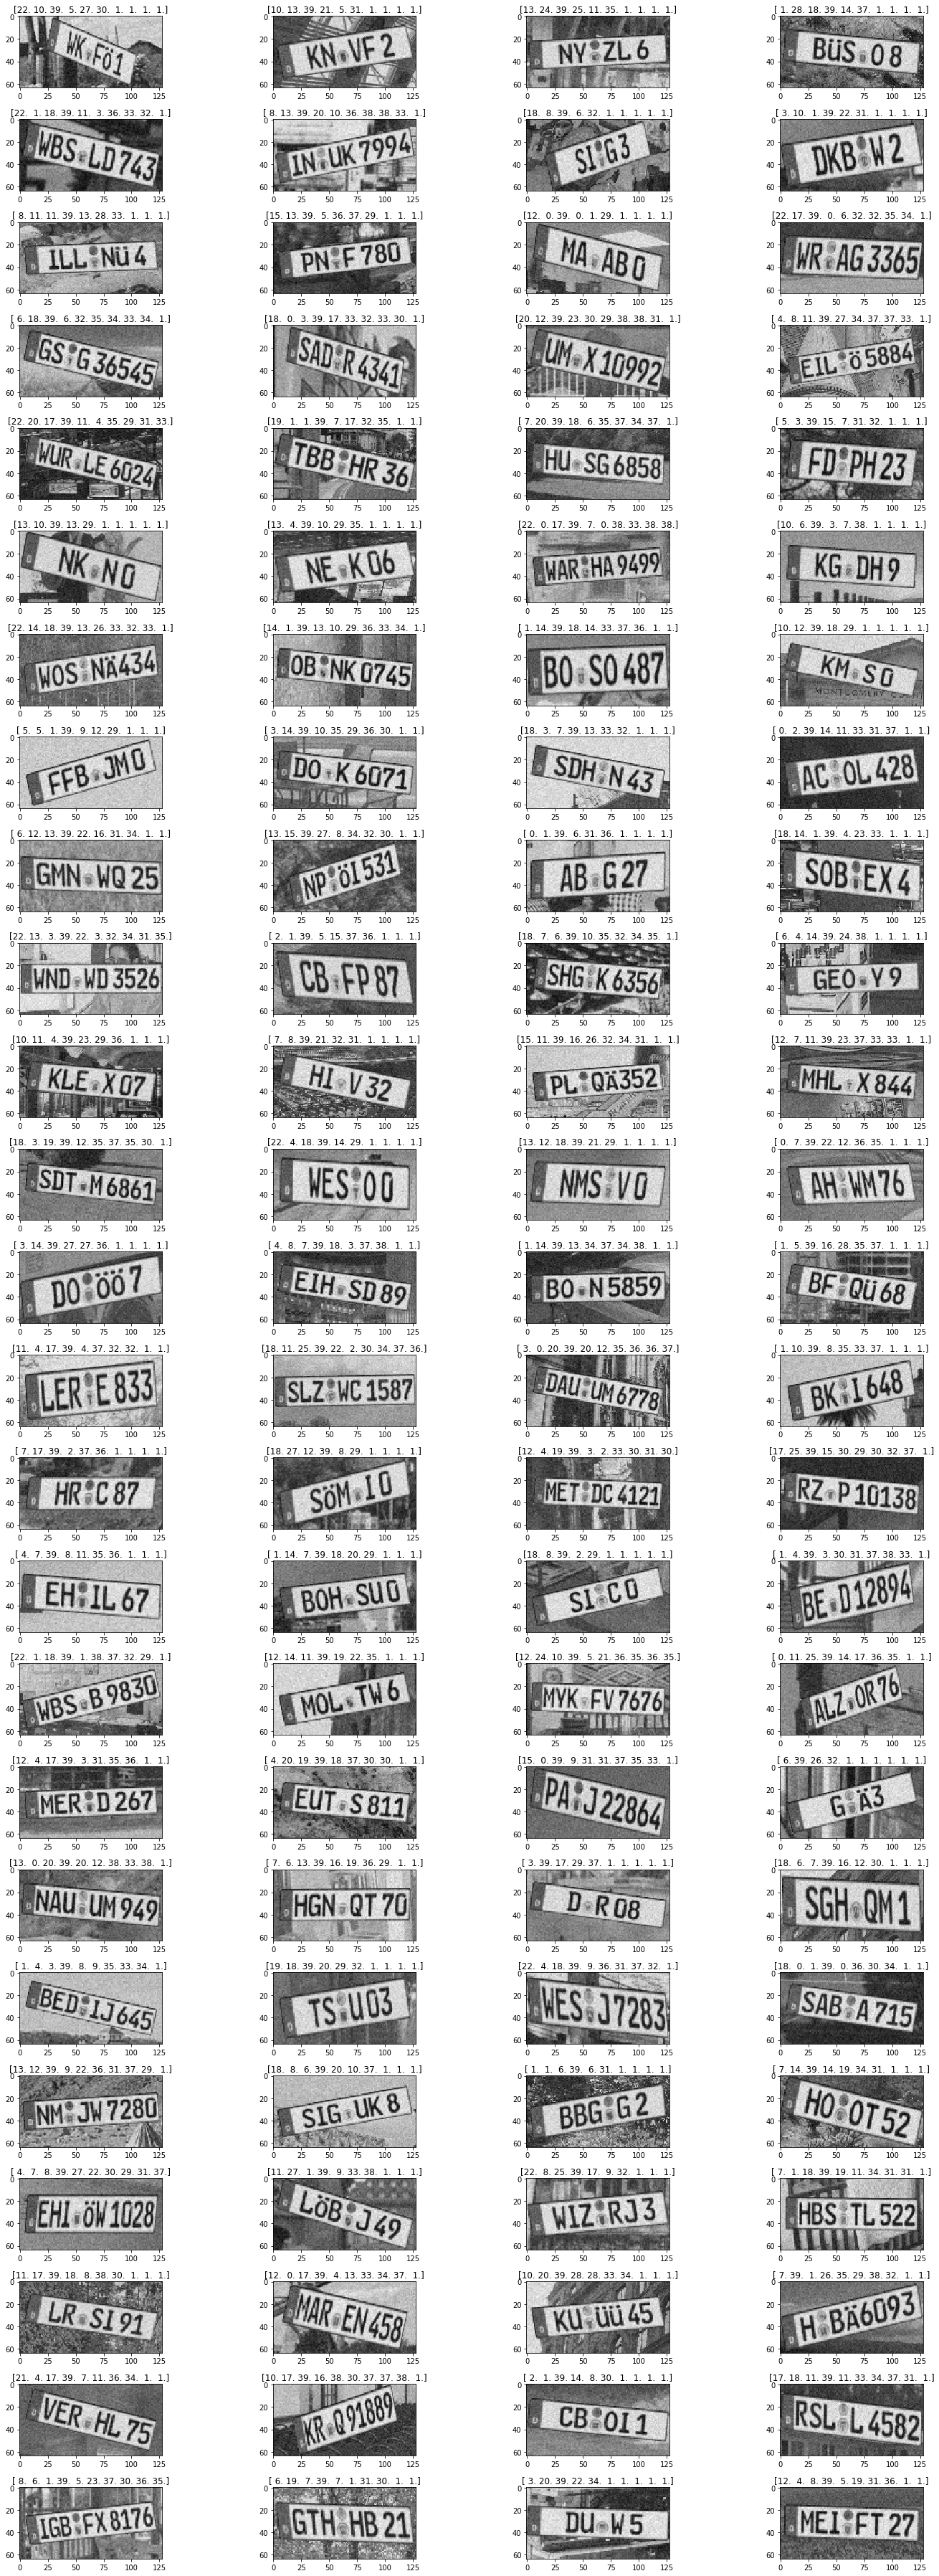

In [4]:
from pyimagesearch.io import Hdf5DatasetLoader
from license_plate_image_augmentator import LicensePlateImageAugmentator
from licence_plate_dataset_generator import LicensePlateDatasetGenerator
from label_codec import LabelCodec
import skimage

loader = Hdf5DatasetLoader()
background_images = loader.load(data_path + '/hdf5/background.h5', shuffle=True, max_items=10000)
    
augmentator = LicensePlateImageAugmentator(IMAGE_WIDTH, IMAGE_HEIGHT, background_images)
train_generator = LicensePlateDatasetGenerator(X_train, y_train, IMAGE_WIDTH, IMAGE_HEIGHT,
                                               POOL_SIZE, MAX_TEXT_LEN, BATCH_SIZE, augmentator)

val_generator = LicensePlateDatasetGenerator(X_test, y_test, IMAGE_WIDTH, IMAGE_HEIGHT,
                                             POOL_SIZE, MAX_TEXT_LEN, BATCH_SIZE, augmentator)

inputs, outputs = next(train_generator.generator())

def plotImages(images_arr, labels, rows, columns):
    fig, axes = plt.subplots(rows, columns, figsize=(20,50))
    axes = axes.flatten()
    for img, label, ax in zip(images_arr, labels, axes):
        img = img.T.reshape(IMAGE_HEIGHT, IMAGE_WIDTH)
        ax.set_title(label)
        ax.imshow(img, cmap='gray')
    plt.tight_layout()
    plt.show()
        
plotImages(inputs["input"], inputs["labels"], int(BATCH_SIZE / 4), 4)

### Create and train the OCR-Network

In [5]:
from tensorflow.keras.optimizers import SGD, Adam, Adagrad, Adadelta, RMSprop
from tensorflow.python.keras import Input
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.python.keras.models import Model
from pyimagesearch.nn.conv import OCR
from label_codec import LabelCodec

def get_optimizer(optimizer):
    if optimizer == "sdg":
        return SGD(lr=1e-2, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)
    if optimizer == "rmsprop":
        return RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
    if optimizer == "adam":
        return Adam(lr=0.001, decay=0.001 / config.NUM_EPOCHS)
        # Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    if optimizer == "adagrad":
        return Adagrad(lr=0.01, epsilon=1e-08, decay=0.0)
    if optimizer == "adadelta":
        return Adadelta(lr=1.0, rho=0.95, epsilon=1e-08, decay=0.0)
    
class CTCLoss(tf.keras.losses.Loss):

    def __init__(self, input_length, label_length, name='CTCLoss'):
        super().__init__(name=name)
        self.input_length = input_length
        self.label_length = label_length

    def call(self, labels, predictions):
        loss = tf.keras.backend.ctc_batch_cost(labels, predictions, self.input_length, self.label_length)
        loss = tf.reduce_mean(loss)
        return loss

tf.compat.v1.disable_eager_execution()

labels = Input(name='labels', shape=(MAX_TEXT_LEN,), dtype='float32')
input_length = Input(name='input_length', shape=(1,), dtype='int64')
label_length = Input(name='label_length', shape=(1,), dtype='int64')

inputs, predictions = OCR.build((IMAGE_WIDTH, IMAGE_HEIGHT, 1), POOL_SIZE, len(LabelCodec.ALPHABET) + 1)

train_model = Model(inputs=[inputs, labels, input_length, label_length], outputs=predictions)
train_model.add_loss(CTCLoss(input_length, label_length)(labels, predictions))
train_model.compile(loss=None, optimizer=get_optimizer(OPTIMIZER))

train_model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 128, 64, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 64, 16)  160         input[0][0]                      
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 64, 16)  64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 64, 16)  0           batch_normalization[0][0]        
______________________________________________________________________________________________

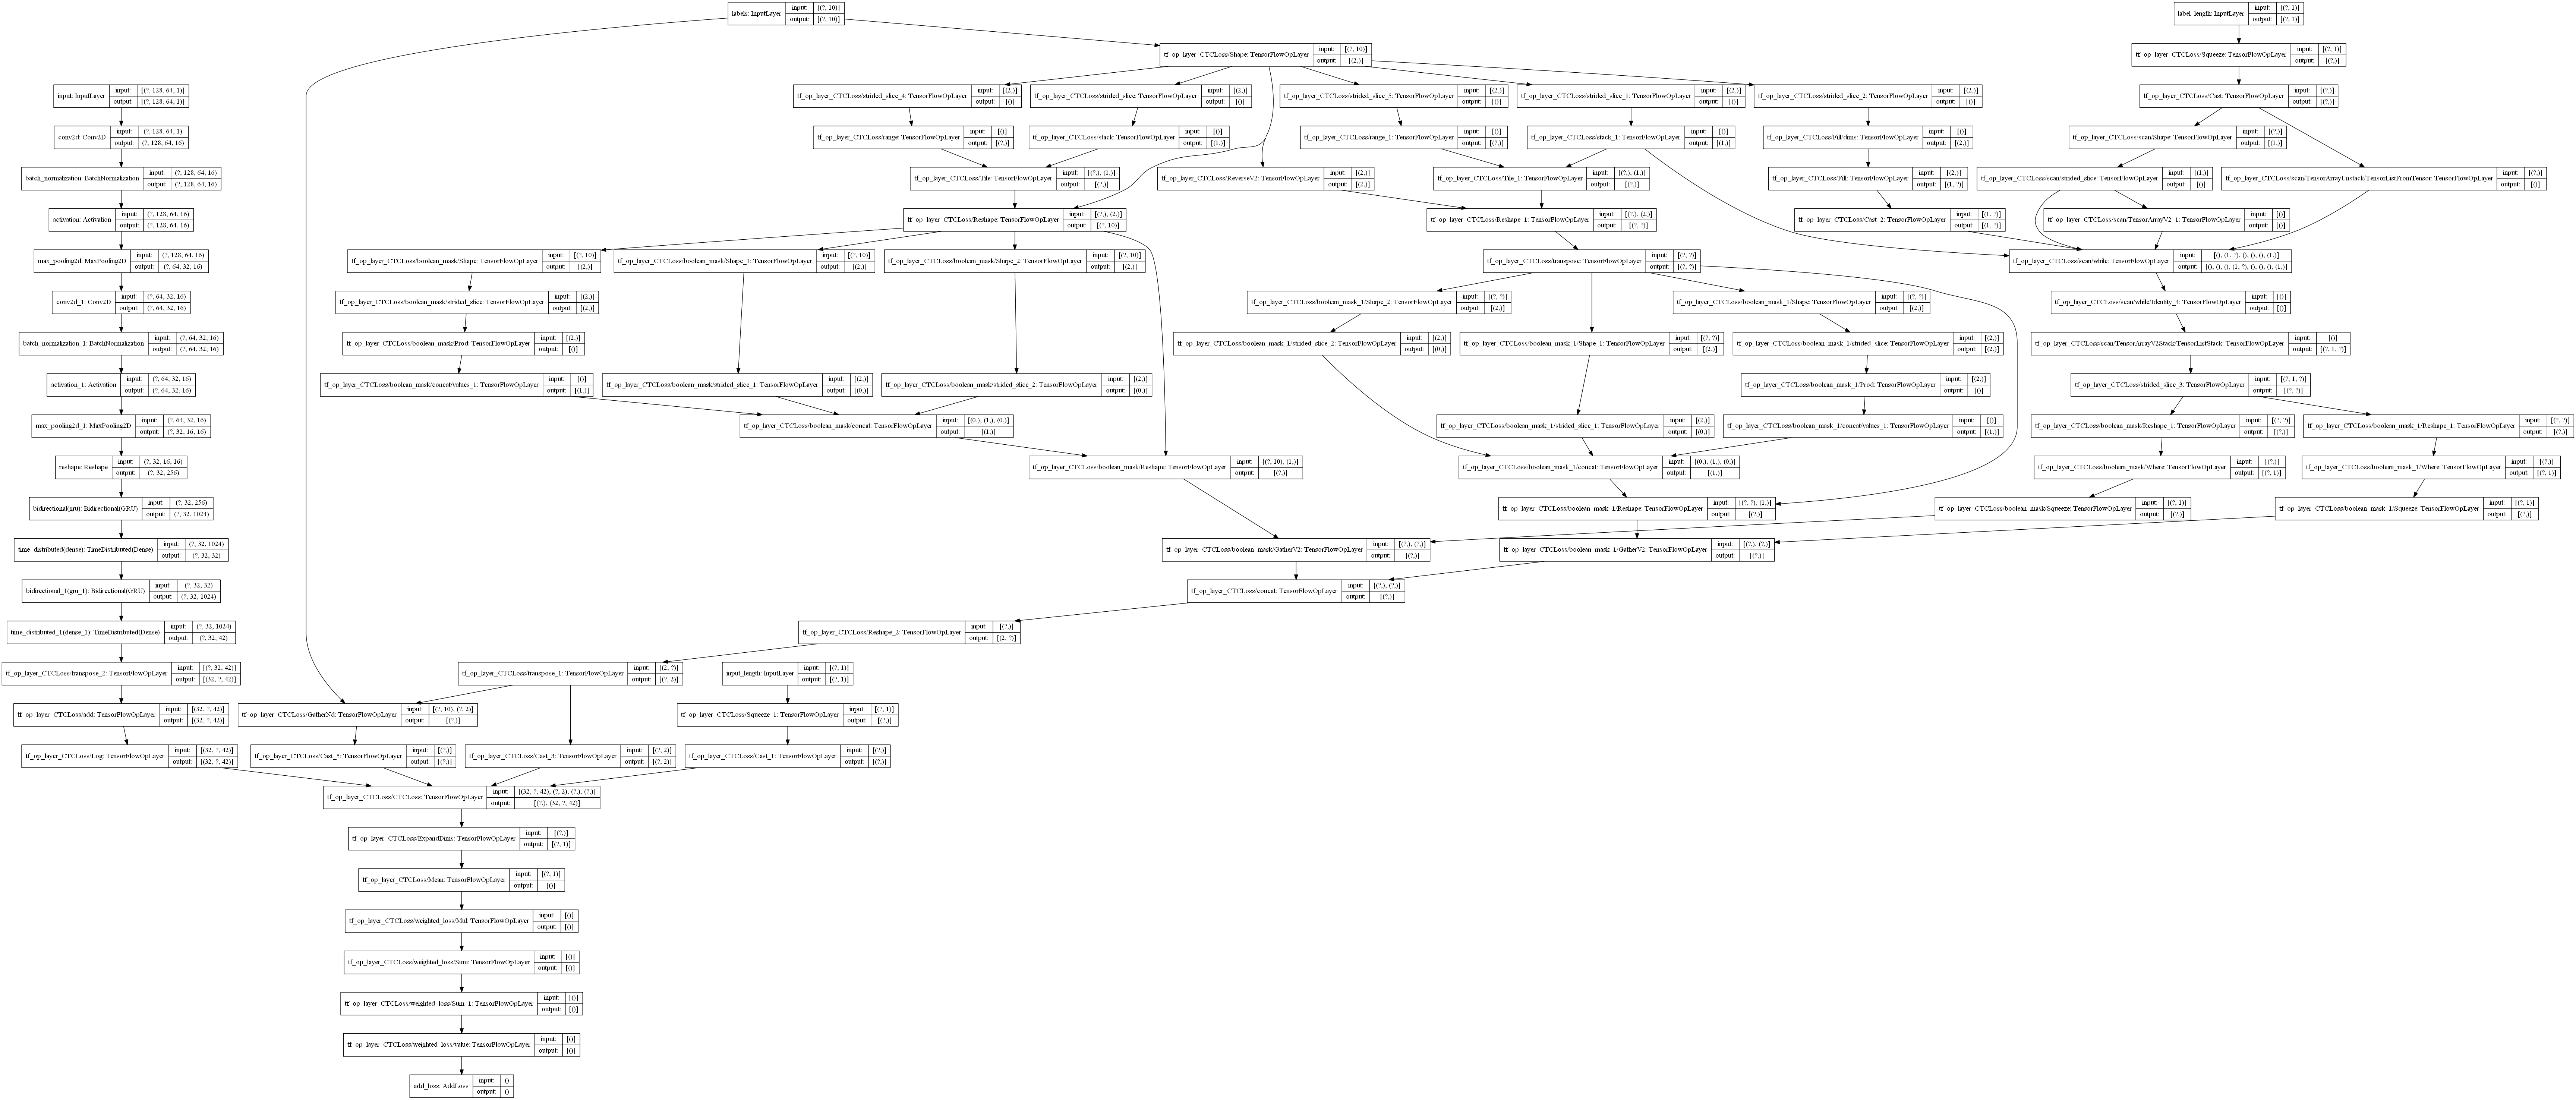

In [6]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

model_architecture_file = os.path.sep.join(["documentation", MODEL_NAME]) + '.png'
plot_model(train_model, to_file=model_architecture_file, show_shapes=True)
Image(filename=model_architecture_file)

In [6]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from pyimagesearch.callbacks import CustomModelCheckpoint

def get_callbacks(weights_path, optimizer):    
    callbacks = [
        EarlyStopping(monitor='loss', min_delta=0.01, patience=5, mode='min', verbose=1),
        CustomModelCheckpoint(model_to_save=train_model, filepath=weights_path, monitor='loss', verbose=1, save_best_only=True, mode='min'),
        ReduceLROnPlateau(monitor='loss', factor=0.1, patience=2, verbose=1, mode='min', min_delta=0.01, cooldown=0, min_lr=0),
        TensorBoard(log_dir=os.path.join("logs", optimizer))]
    return callbacks

#### Train the network

In [7]:
history = train_model.fit(
    train_generator.generator(),
    steps_per_epoch=train_generator.numImages // BATCH_SIZE,
    validation_data=val_generator.generator(),
    validation_steps=val_generator.numImages // BATCH_SIZE,
    epochs=NUM_EPOCHS,
    callbacks=get_callbacks(MODEL_WEIGHTS_PATH, OPTIMIZER), verbose=1)

Epoch 1/1000
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


163/652 [======>.......................] - ETA: 5:03 - loss: 21.6562
Epoch 00001: loss improved from inf to 24.74627, saving model to output\adagrad\clpr-model-weights.h5
652/652 [==============================] - 558s 855ms/step - loss: 24.7463 - val_loss: 21.6562
Epoch 2/1000
163/652 [======>.......................] - ETA: 5:13 - loss: 20.6831
Epoch 00002: loss improved from 24.74627 to 21.59296, saving model to output\adagrad\clpr-model-weights.h5
652/652 [==============================] - 557s 855ms/step - loss: 21.5930 - val_loss: 20.6831
Epoch 3/1000
163/652 [======>.......................] - ETA: 5:28 - loss: 18.4846
Epoch 00003: loss improved from 21.59296 to 20.51288, saving model to output\adagrad\clpr-model-weights.h5
652/652 [==============================] - 608s 933ms/step - loss: 20.5129 - val_loss: 18.4846
Epoch 4/1000
163/652 [======>.......................] - ETA: 5:06 - loss: 12.6474
Epoch 00004: loss improved from 20.51288 to 17.64692, saving model to output\adagrad

Epoch 24/1000
163/652 [======>.......................] - ETA: 5:05 - loss: 0.0781
Epoch 00024: loss improved from 0.41493 to 0.38544, saving model to output\adagrad\clpr-model-weights.h5
652/652 [==============================] - 554s 850ms/step - loss: 0.3854 - val_loss: 0.0781
Epoch 25/1000
163/652 [======>.......................] - ETA: 5:10 - loss: 0.0724
Epoch 00025: loss improved from 0.38544 to 0.35925, saving model to output\adagrad\clpr-model-weights.h5
652/652 [==============================] - 567s 869ms/step - loss: 0.3593 - val_loss: 0.0724
Epoch 26/1000
163/652 [======>.......................] - ETA: 5:01 - loss: 0.0678
Epoch 00026: loss improved from 0.35925 to 0.34194, saving model to output\adagrad\clpr-model-weights.h5
652/652 [==============================] - 549s 842ms/step - loss: 0.3419 - val_loss: 0.0678
Epoch 27/1000
163/652 [======>.......................] - ETA: 5:01 - loss: 0.0649
Epoch 00027: loss improved from 0.34194 to 0.32014, saving model to output\ada

Epoch 47/1000
163/652 [======>.......................] - ETA: 5:02 - loss: 0.0297
Epoch 00047: loss did not improve from 0.16933
652/652 [==============================] - 550s 844ms/step - loss: 0.1723 - val_loss: 0.0297
Epoch 48/1000
163/652 [======>.......................] - ETA: 5:01 - loss: 0.0288
Epoch 00048: loss did not improve from 0.16933

Epoch 00048: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-07.
652/652 [==============================] - 551s 845ms/step - loss: 0.1735 - val_loss: 0.0288
Epoch 49/1000
163/652 [======>.......................] - ETA: 5:04 - loss: 0.0301
Epoch 00049: loss did not improve from 0.16933
652/652 [==============================] - 550s 844ms/step - loss: 0.1800 - val_loss: 0.0301
Epoch 00049: early stopping


#### Create and save prediction model

In [8]:
from tensorflow.keras.models import save_model

predict_model = Model(inputs=inputs, outputs=predictions)
predict_model.load_weights(MODEL_WEIGHTS_PATH)
save_model(predict_model, filepath=MODEL_PATH, save_format="h5")